# Ray-Tracing Code + Convolution


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg
import copy
import itertools
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import signal

In [2]:
def refract(n, r, l):
    '''
    Inputs:
    n (array of three elements): normal vector at incident point of light vector
    r (float): refractive index ratio
    R (float): radius of sphere (sphere), cross-sectional radius (cylinder)
    l (array of three elements): incident light vector
    
    Returns:
    v_refract (array of three elements): refracted light vector
    '''
    
    # Implement Snell's Law
    c = 0-np.dot(n, l)
    temp = 1-(r**2)*(1-(c**2))
    if temp < 0:
        return -1
    A = (r*c - np.sqrt(temp))
    v_refract = r*np.array([0,0,1]) + A*n
    return v_refract

def reflect(n, nu1, nu2, l):
    '''
    Inputs:
    n (vector): normal vector
    nu1 (float):
    nu2 (float):
    l (array of three elements): incident light vector
    
    Returns:
    T (float): Transmittance as a percentage of original intensity
    '''
    theta_i = 0-np.dot(n, l)
    # theta_t =  np.arcsin(np.sqrt(((nu1/nu2)**2)*(1-(np.cos(theta_i))**2)))
    if 1 - ((nu1/nu2)**2)*(1-theta_i**2) < 0:
        return 1
    costheta2 = np.sqrt(1 - ((nu1/nu2)**2)*(1-theta_i**2))
    Rs=((nu1*theta_i-nu2*costheta2)/(nu1*theta_i+nu2*costheta2))**2 
    Rp=((nu1*costheta2-nu2*theta_i)/(nu1*costheta2+nu2*theta_i))**2
    R = 0.5*(Rs + Rp)
    T = 1 - R
    return T

def get_ray(R, x, y, nu1, nu2,  original_intensity, suppress=True, geometry=["sphere"]):
    
    '''
    Inputs:
    R (float): radius
    x (float): x-coordinate, less than R
    y (float): y-coordinate, less than R
    r (float): refractive index ratio
    suppress (bool): Suppresses print statements
    original_intensity (float): Original intensity
    
    Returns:
    array (array of ten elements): exiting light vector (0-2), path length (3), exit point (4-6),
    two transmittance factors (7-8), and original intensity
    '''
    
    if geometry[0] == "sphere":
        # Get z coordinate and entry point
        z_sq = np.square(R)-np.square(x)-np.square(y)
        if z_sq < 0:
            return np.array([0,0,1,float('inf'),x,y,0,1,1,original_intensity])
        z = -np.sqrt(z_sq)
        entry_point = np.array([x,y,z])
        if not suppress:
            print("The entry point is",  entry_point)
        n_in = np.array([x/R,y/R,z/R])
        # Get surface normal vector
        if not suppress:
            print("The normalised entry vector is", n_in)
    elif geometry[0] == "cone":
        length = geometry[1]
        cross_section_radius = R*x/length 
        z_sq = np.square(cross_section_radius) - np.square(y)
        entry_point = np.array([x,y,np.sqrt(z_sq)])
        n_in = np.array([-x, y, sqrt(z_sq)])/(np.square(x) + np.square(y) + z_sq) # Check
    
    ## Get entry transmittance factor and the first refraction vector
    transmit1 = reflect(n_in, nu1, nu2, np.array([0,0,1])) 
    v_refract1 = refract(n_in, r, np.array([0,0,1]))
    
    # if v_refract1 is erroneous (due to TIR), return the trivial vector (0,0,1), 'inf' and the entry point
    if type(v_refract1) == int:
        return np.array([0,0,1,float('inf'),x,y,z,1,1,original_intensity])
    
    # Normalize v_refract1
    v_refract1 = v_refract1/linalg.norm(v_refract1)
    if not suppress:
        print("v_refract1 is", v_refract1)
        print(linalg.norm(v_refract1))
    
    # An analytical expression for t: the depth parameter
    t = 0 - (2*np.dot(entry_point, v_refract1))/np.dot(v_refract1, v_refract1)
    if not suppress:
        print("t is", t)
    
    # Eqn of a ray through the object
    exit_point = entry_point + t*v_refract1
    if not suppress:
        print("The exit point is", exit_point)
        print("The magnitude of the exit point is", exit_point[0]**2 + exit_point[1]**2 + exit_point[2]**2)
    
    # Get normal vector at exit point
    if geometry[0] == "sphere":
        n_out = 0 - exit_point/linalg.norm(exit_point)
        if not suppress:
            print("The normalised exit vector is", n_out)
    elif geometry[0] == "cone":
        x, y, z = exit_point[0], exit_point[1], exit_point[2]
        cross_section_radius = x/length*R
        n_in = np.array([-x, y, sqrt(z_sq)])/(np.square(x) + np.square(y) + z_sq)
    
    # Get exit transmittance factor and the second refraction vector
    transmit2 = reflect(n_out, nu2, nu1, np.array([0,0,1])) 
    v_refract2 = refract(n_out, 1/r, v_refract1)
    
    # if v_refract2 is erroneous (due to TIR), return the trivial vector (0,0,1), 'inf' and the exit point
    if type(v_refract2) == int:
        return np.array([0,0,1,float('inf'),x,y,exit_point[2],1,1,original_intensity])
    v_refract2 = v_refract2/linalg.norm(v_refract2)
    
    # Append t, exit_point and first and second transmittance factors to v_refract2 to get an array of nine elements
    array = np.append(v_refract2, t)
    array = np.concatenate([array, exit_point])
    array = np.concatenate([array, [transmit1, transmit2]])
    array = np.append(array, original_intensity)
    return array

In [3]:
def create_matrix(grid_params, R, nu1, nu2, intensity, geometry=["sphere"]):
    
    '''
    grid_params (array of six elements): min_x, max_x, min_y, max_y, sampling points along x and y axes
    R (float): Radius of sphere
    r (float): refractive index ratio
    '''
    
    min_x, max_x, min_y, max_y, points_x, points_y = grid_params
    data = np.zeros((10,points_x,points_y), dtype="complex")
    x_axis = np.linspace(min_x, max_x, points_x)
    y_axis = np.linspace(min_y, max_y, points_y)
    for i in range(points_x):
        for j in range(points_y):
            ans = get_ray(R,x_axis[i],y_axis[j],nu1,nu2, intensity, geometry)
            for k in range(10):
                data[k][i][j] = ans[k]
    return data

def sphere_attenuation(original_intensity, data, beta, R, grid_params, tol=0.05):
    
    '''
    Performs attenuation and phases shift for a matrix of rays.
    
    Inputs:
    original_intensity (float): intensity of light ray after attenuation
    data (3d matrix): Data matrix from create_matrix
    beta (float): beta constant of material
    R (float)
    grid_params (array of ten elements): same as above
    tol (float): Tolerance level for unblocked light

    Returns:
    array (array of ten elements): exiting light vector (0-2), path length (3), exit point (4-6), 
    two transmittance factors (7-8) and electric field (9)
    '''
    
    data2 = copy.deepcopy(data)
    min_x, max_x, min_y, max_y, points_x, points_y = grid_params

    # Attenuate light
    #data2[9][:][:] = data2[9][:][:]*data2[7][:][:]*data2[8][:][:]*np.exp(-4*original_intensity*np.pi*beta*data2[3][:][:]/(hc))
    
    # Create electric field
    phase_shift_factor = data2[3][:][:]*np.exp(data[3][:][:]*(-1j)*np.sqrt(intensity)*(1-delta+1j*beta)/(hc))
    data2[9][:][:] = np.multiply(data[9][:][:], phase_shift_factor)
    data2[9][:][:] = data2[9][:][:]*data2[7][:][:]*data2[8][:][:]
    
    # Add in light that is not blocked by sphere
    x_axis = np.linspace(min_x, max_x, points_x)
    y_axis = np.linspace(min_y,  max_y, points_y)
    for i in range(data2.shape[1]):
        for j in range(data2.shape[2]):
            dist_check = (x_axis[i])**2 + (y_axis[j])**2
            if dist_check > R**2 - tol:
                data2[9][i][j] = 0.9999
    return data2

def plot_intensity(matrix, grid_params):
    
    '''
    matrox (3d matrix): data matrix
    grid_params (array of six elements): same as above
    '''
    
    X = matrix[0][:][:]
    Y = matrix[1][:][:]
    Z = np.square(np.real(matrix[9][:][:]))
    np.savetxt("z.csv", Z, delimiter=",")
    
    X_radial = []
    intensity_profile = []
    for i in range(matrix.shape[1]):
        X_radial.append(matrix[0][i][i])
        intensity_profile.append(Z[i][i])

    plt.figure(figsize=(10,10))
    plt.imshow(Z, cmap='Blues_r')

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z)
    
    ax=fig.gca()
    plt.figure(figsize=(30,10))
    plt.tick_params(labelsize=20)
    plt.plot(X_radial, intensity_profile/max(intensity_profile))

In [4]:
# Assume distance is large relative to size of molecule, so all rays are propagated the same distance

def propagate(data, E, d, norm = False):
    '''
    Propagates a wave via convolution.
    Args:
        data (ndarray): 3D array of the discretized wave to be propagated
        E      (float): monochromatic wave energy in vacuum
        d      (float): distance to propagate the wave
        norm    (bool): if True, normalizes the output grid
    Outputs:
        propagated_wave (ndarray): xy grid of propagated waveform values
    '''
    
    wave = data[9][:][:]
    
    ## Physical constants
    h = 6.6260701e-34    # [J.s]: Planck's constant
    c = 2.99792458e8     # [m/s]: Speed of light

    ## Vacuum wavelength and wavevector
    lambda_vac = h*c/E            # [m]: wavelength
    k_vac = 2*np.pi/lambda_vac    # [1/m]: wavevector
        
    ## Prepare a k-space grid
    dim = wave.shape
    kx = (np.arange(dim[0]) - dim[0] / 2) * 2 * np.pi / (dim[0] * dx)
    ky = (np.arange(dim[1]) - dim[1] / 2) * 2 * np.pi / (dim[1] * dy)
    kxg, kyg = np.meshgrid(kx, ky, indexing = 'ij')
    
    ## Initialize the kernel grid
    kernel = np.exp(-1j * d * (kxg**2 + kyg**2) / (2.0 * k_vac))
    
    ## np.fft.fft assumes the kx, ky = 0 on the corner. np.fft.fftshift centers the k-space grid at (0,0)
    kernel = np.fft.fftshift(kernel)

    ## Propagate the wave through convolution
    propagated_wave = np.fft.ifft2(kernel * np.fft.fft2(wave))
    np.savetxt("prop.csv", propagated_wave, delimiter=",")

    if norm:
        propagated_wave = propagated_wave / np.sqrt(sum(sum(propagated_wave)))
    else:
        data[9][:][:] = propagated_wave
    
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            data[9,i,j] = propagated_wave[i][j]
    
    return data

In [5]:
# Run code

intensity = 5.928 # in eV/(m^2)

# Physical setup values
nbins_x = 600
nbins_y = 600
min_x, max_x = -20, 20
min_y, max_y = -20, 20
dx = (max_x - min_x)/nbins_x
dy = (max_y - min_y)/nbins_y
sampling_params = [min_x, max_x, min_y, max_y, nbins_x, nbins_y] # in um
R = 10   # in um
distance = 1e5      # in um
hc= 1.23984193 # in eVum

# n-Heptane values
delta = 1.51026588E-05
beta  = 3.45463604E-08
nu1    = 1
nu2    = 1 - delta
r     = nu1 / nu2


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
C:\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1714: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[which_pt] = np.array(ps2[i1]) - np.array(ps2[i2])
C:\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1715: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[which_pt] = np.array(ps2[i2]) - np.array(ps2[i3])
C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


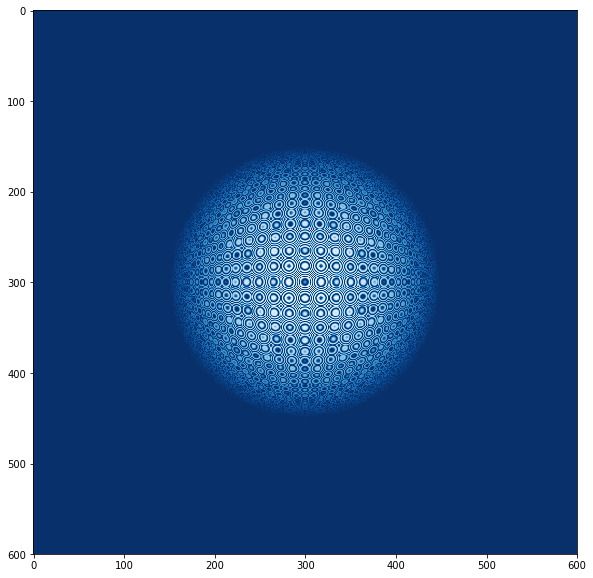

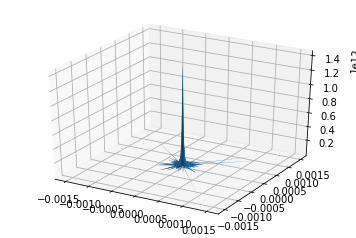

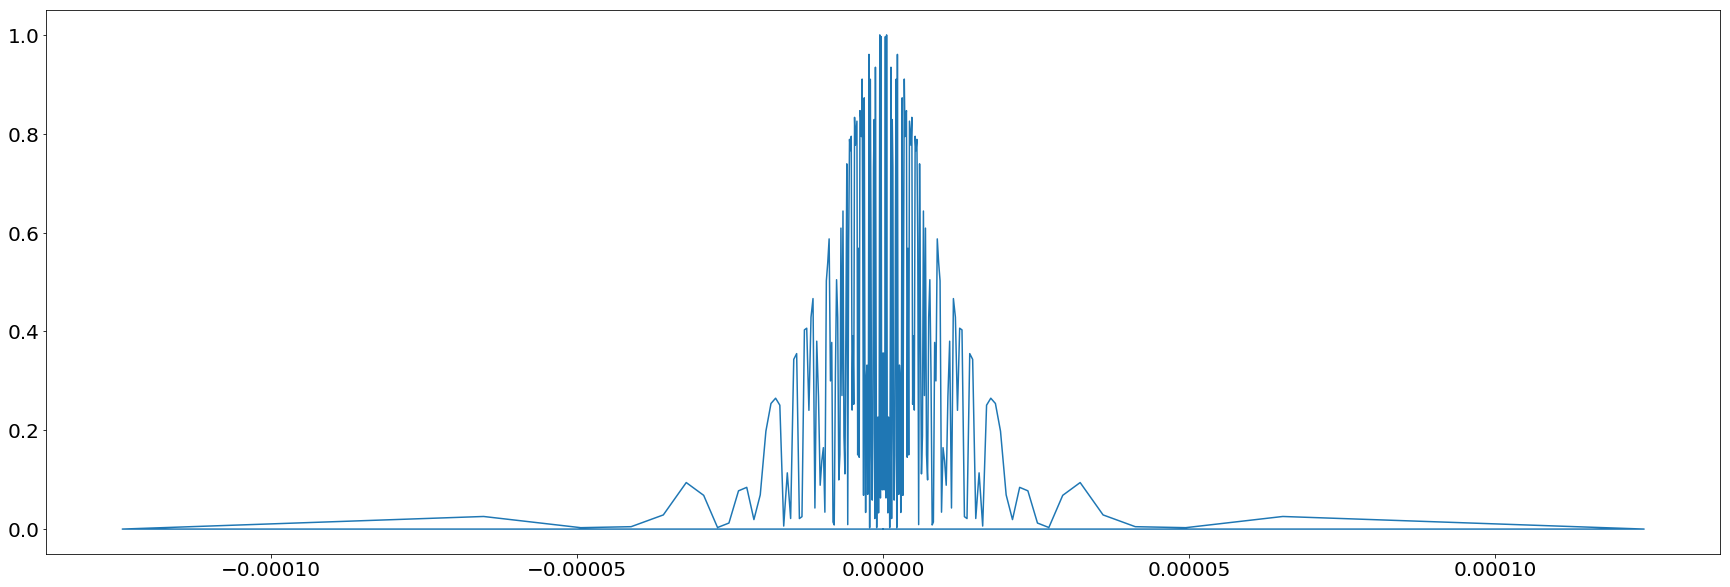

In [20]:
# Run code

intensity = 60000 # in eV/(m^2)

# Physical setup values
nbins_x = 600
nbins_y = 600
min_x, max_x = -20, 20
min_y, max_y = -20, 20
dx = (max_x - min_x)/nbins_x
dy = (max_y - min_y)/nbins_y
sampling_params = [min_x, max_x, min_y, max_y, nbins_x, nbins_y] # in um
R = 10   # in um
distance = 1e5      # in um
hc= 1.23984193 # in eVum

# n-Heptane values
delta = 1.51026588E-05
beta  = 3.45463604E-08
nu1    = 1
nu2    = 1 - delta
r     = nu1 / nu2

data = create_matrix(sampling_params, R, nu1, nu2, intensity)
data2 = sphere_attenuation(intensity, data, beta, R, sampling_params)
data3 = propagate(data2, intensity, distance)
result = plot_intensity(data2, sampling_params)

In [6]:
def gaussian(x,mu,sigma):
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp( -( ((x-mu)/sigma)**2 )/2)

def makeGaussianHarmonics(E0, N_harmonics, N_samples, E_lim = None, sigmas = None):
    
    ''' Returns a normalized intensity distribution of Gaussians
        centered at harmonics of E0.
    '''
    
    centroids = [i*E0 for i in range(1,N_harmonics+2)]

    if sigmas is None:
        sigmas = [0.035*E for E in centroids]

    if E_lim is None:
        energy_axis = np.linspace(E0 * 0.5, E0 * 1.5, N_samples)
    else:
        energy_axis = np.linspace(E_lim[0], E_lim[1], N_samples)
        
    beam_profile = 0
    for n,E in enumerate(centroids):
        beam_profile += gaussian(energy_axis, centroids[n], sigmas[n])

    beam_profile /= sum(beam_profile) # normalize the profile
    
    return [energy_axis, beam_profile]

In [13]:
def polychromatic(E0, n_harmonics, n_samples, sampling_params):
    '''
    E0 (float): Total energy
    n_harmonics (integer): Number of harmonicsa
    n_samples (integer): Number of samples
    sampling_params (array of six elements): min_x, max_x, min_y, max_y, x_samples, y_samples
    '''
    energy_axis, beam_profile = makeGaussianHarmonics(E0, n_harmonics, n_samples)
    data = create_matrix(sampling_params, R, nu1, nu2, E0)
    for i in range(len(energy_axis)):
        data2 = sphere_attenuation(energy_axis[i], data, beta, R, sampling_params)
        data2[9][:][:] = data2[9][:][:] * beam_profile[i]
        if not i:
            aggregate = data2
        aggregate[9][:][:] = aggregate[9][:][:] + data2[9][:][:]
    plot_intensity(aggregate, sampling_params)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
C:\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1714: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[which_pt] = np.array(ps2[i1]) - np.array(ps2[i2])
C:\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1715: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[which_pt] = np.array(ps2[i2]) - np.array(ps2[i3])
C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


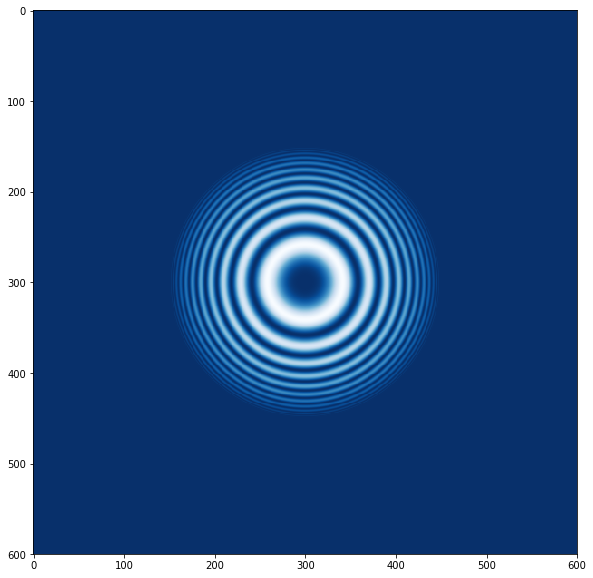

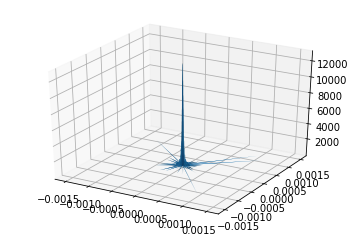

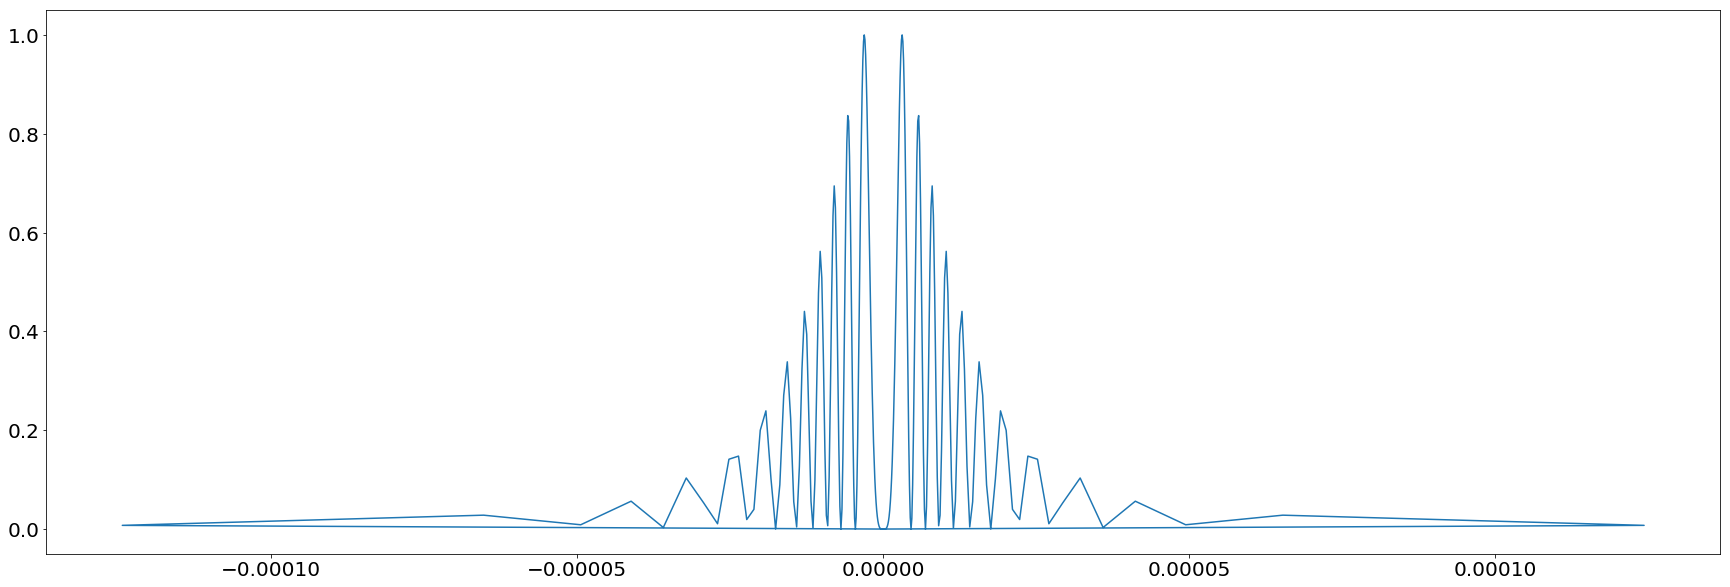

In [15]:
polychromatic(intensity, 6, 100, sampling_params)